In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# df2 = duckdb.sql("""
# select distinct
#     GLOSATIPOESTABLECIMIENTO
# FROM datos_urgencia_consolidados.parquet
# """).df()
# df2
periodo = 365
USE_CUMSUM = True
year_list = ['2017','2018','2019','2022','2023']

In [3]:
#read data from parquet file
#number of days from the beginning of the year to consider in the analysis

common_filter = """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and CodigoDependencia in (9,10,11,12,13,14)
and CodigoRegion is not null
--and GLOSATIPOESTABLECIMIENTO = 'Hospital'
--and CodigoRegion = 13
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019)
--and year(strptime(fecha, '%d/%m/%Y')) in (2022,2023)
--group by CodigoRegion, dayofyear(strptime(fecha, '%d/%m/%Y'))
--group by CodigoRegion, fecha
group by CodigoDependencia, fecha, TipoEstablecimiento
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , IF(GLOSATIPOESTABLECIMIENTO=='Hospital' , 'Hospital','NoHospital') as TipoEstablecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'pediatricos' as grupo_etario
    , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , IF(GLOSATIPOESTABLECIMIENTO=='Hospital' , 'Hospital','NoHospital') as TipoEstablecimiento
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    ,'adultos' as grupo_etario
    , sum(De_15_a_64)  + sum(De_65_y_mas) as atenciones
"""+ common_filter + """
""").df()

df2 = df2.sort_values(by=['year','CodigoRegion', 'TipoEstablecimiento','grupo_etario','nrodia']).reset_index(drop = True)

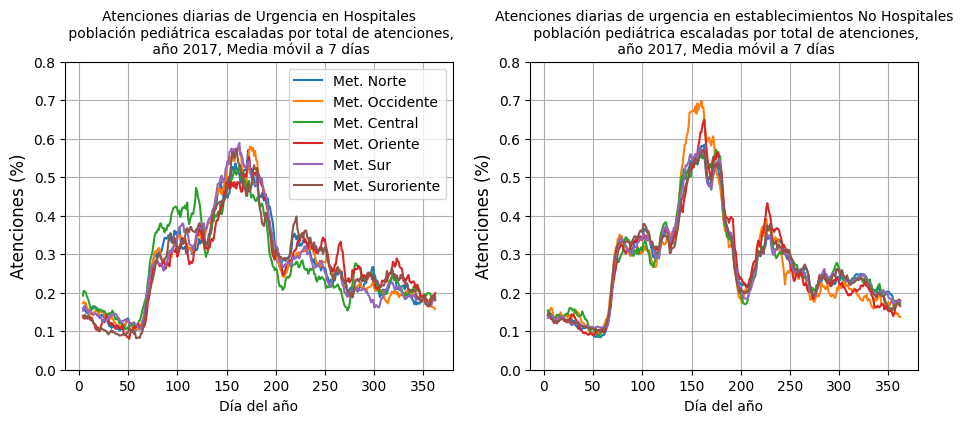

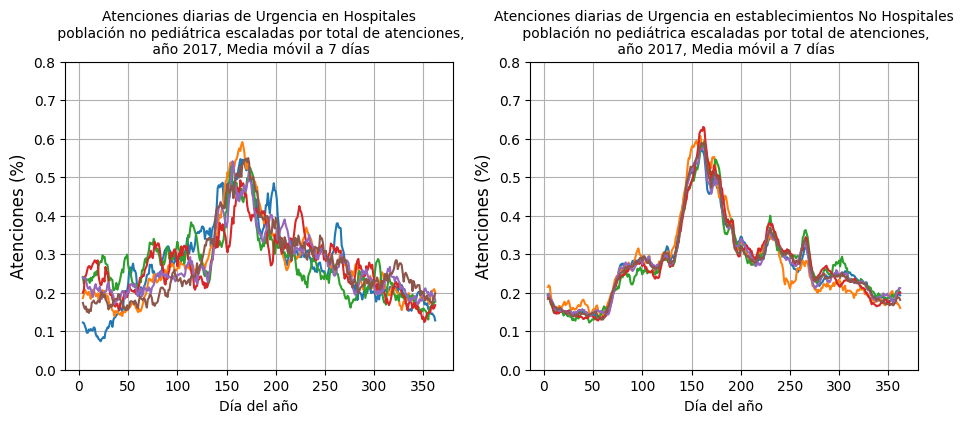

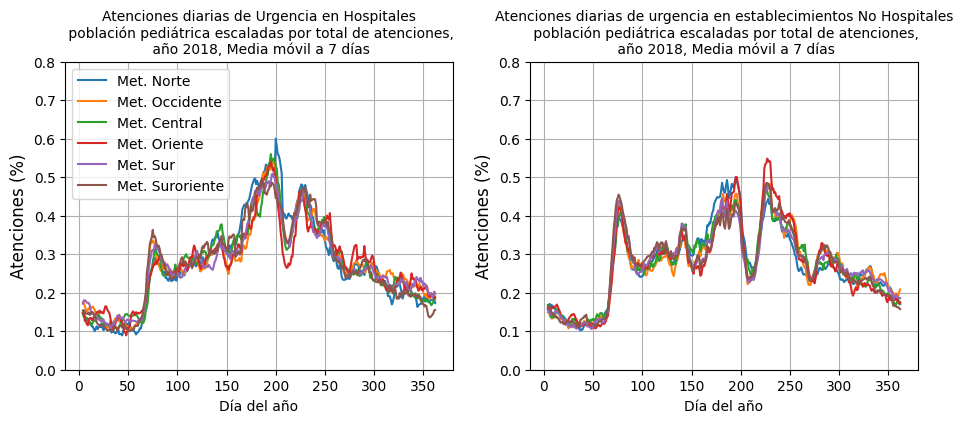

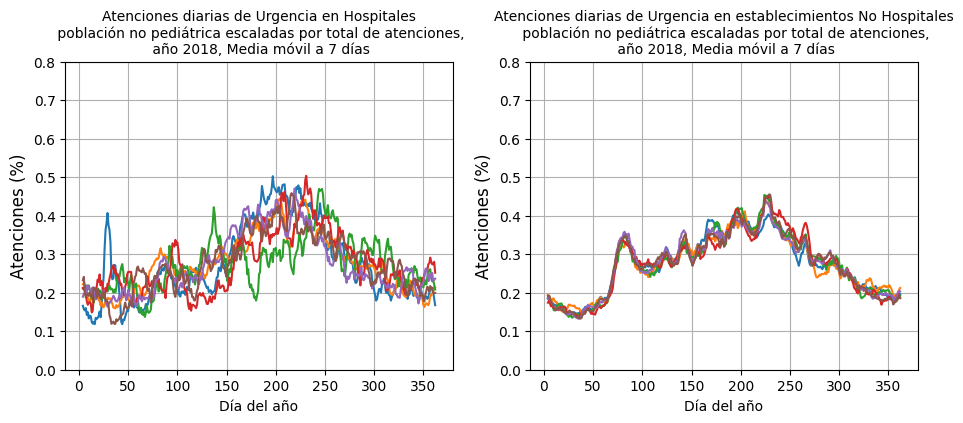

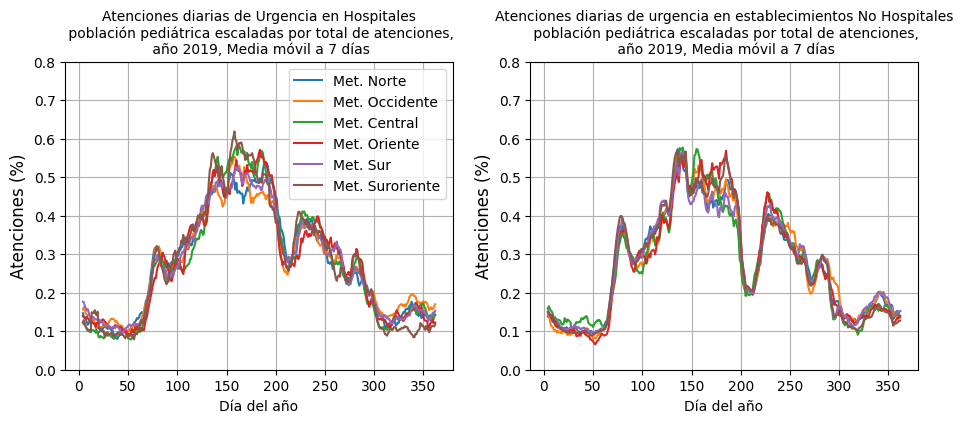

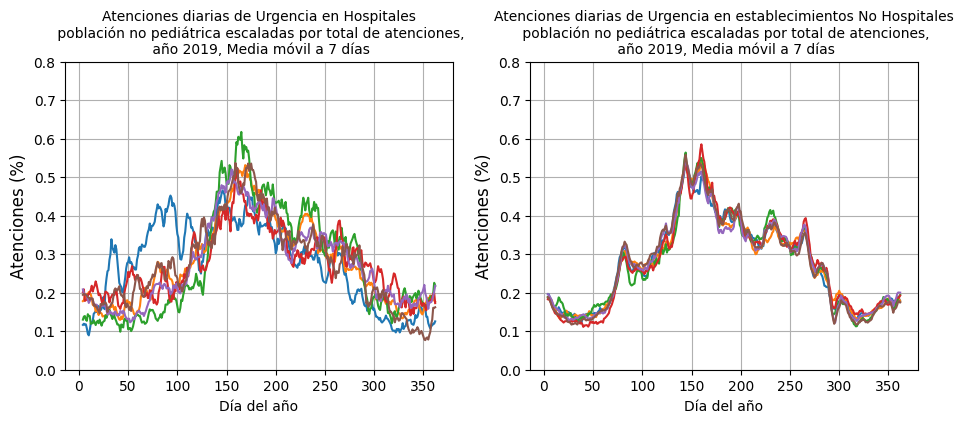

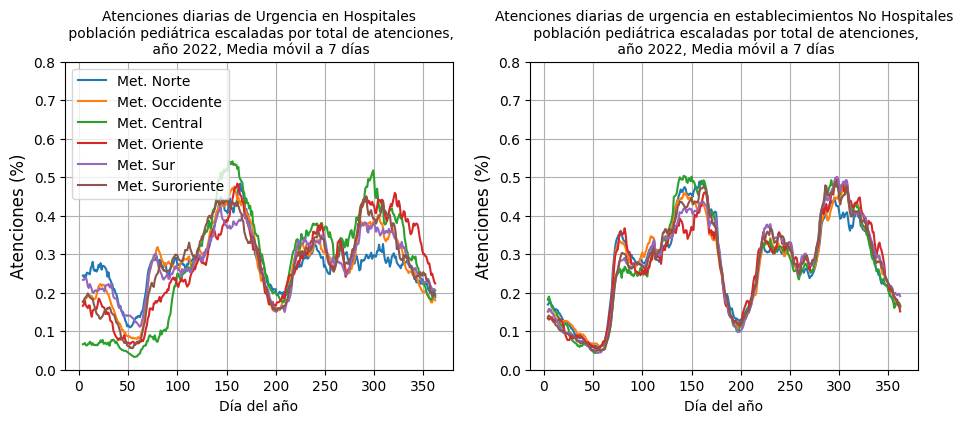

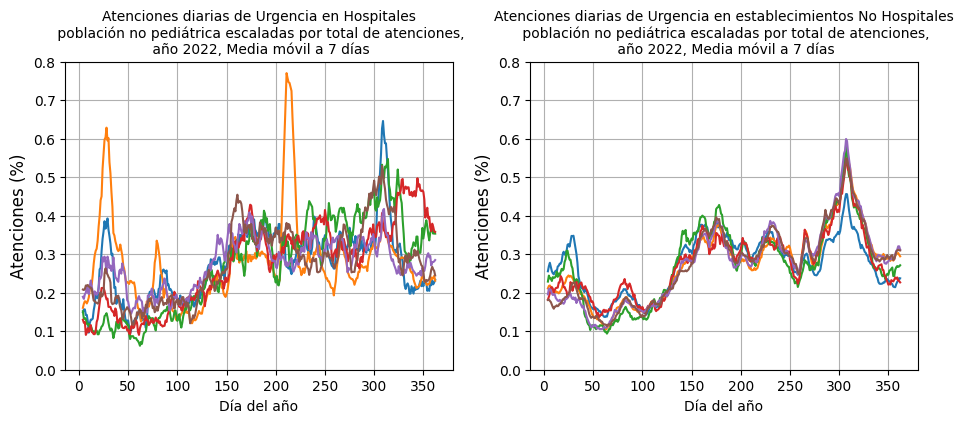

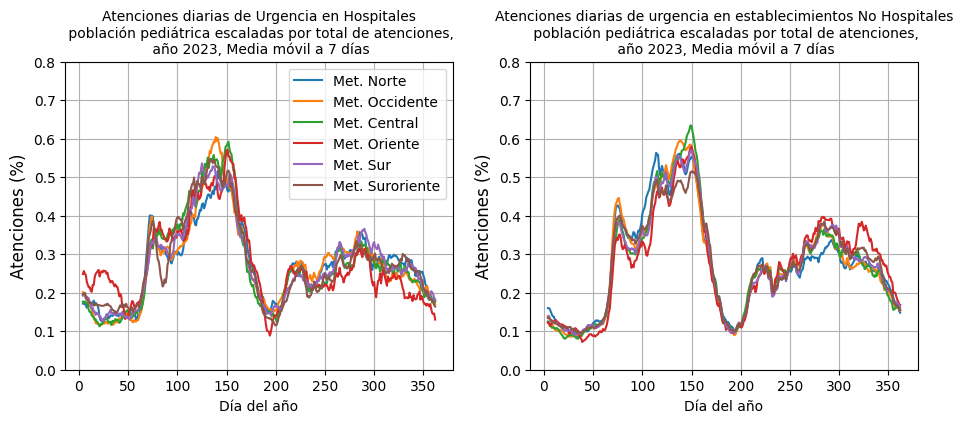

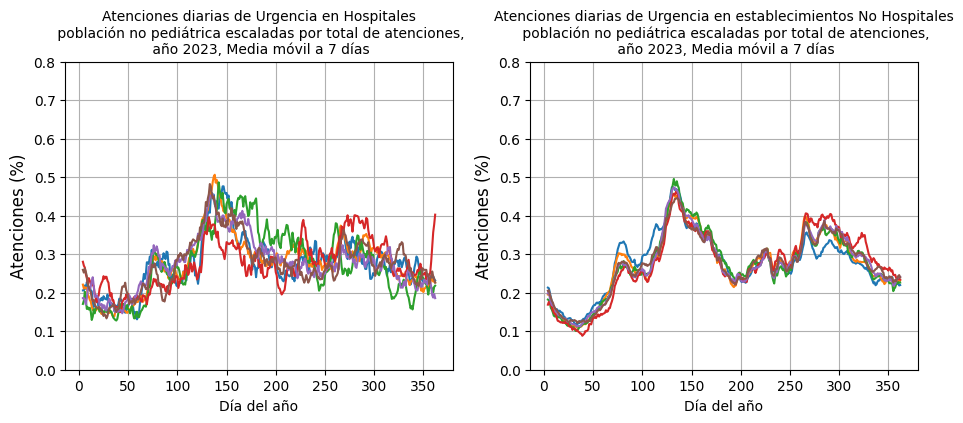

In [4]:
#Comparacion de datos para diferentes grupos etarios para un año fijo
#Full average: Goal to compare populations across years, 
#ages and locations by trying to stablish a baseline reference demand.
#WE scale the data dividing by the total yearly demand in order to distinguish behaviour

for k in range(5):
    year_figure = year_list[k]
    
    df = duckdb.sql("""
    select 
          year(strptime(fecha, '%d/%m/%Y')) as year
        , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
        , CodigoDependencia
        , IF(GLOSATIPOESTABLECIMIENTO=='Hospital' , 'Hospital','NoHospital') as TipoEstablecimiento
        , sum(Menores_1) as Menores_1
        , sum(De_1_a_4) as De_1_a_4
        , sum(De_5_a_14) as De_5_a_14
        , sum(De_15_a_64) as De_15_a_64
        , sum(De_65_y_mas) as De_65_y_mas
        , sum(Menores_1) + sum(De_1_a_4) + sum(De_5_a_14) as pediatricos
        , sum(De_15_a_64) + sum(De_65_y_mas) as adultos
    --    , sum(Menores_1) + sum(De_1_a_4)+ sum(De_5_a_14) + sum(De_15_a_64) + sum(De_65_y_mas) as atenciones
    FROM datos_urgencia_consolidados.parquet
    where IdCausa in (3,4,5,6,10,11) 
    and CodigoDependencia in (9,10,11,12,13,14)
    --where IdCausa =6 and CodigoRegion = 5
    and fecha like '%""" + year_figure + """'
    --and dayofyear(strptime(fecha, '%d/%m/%Y')) <=365
    --and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
    group by year, CodigoDependencia, nrodia, TipoEstablecimiento
    order by year, CodigoDependencia, TipoEstablecimiento, nrodia
    """).df()
    
    # ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 
    fig = plt.figure(figsize = (11,4))
    ax = fig.add_subplot(1,2,1) 
    #targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
    targets = ["pediatricos"]
    #targets = ["adultos"]
    lista_servicios_salud = [9,10,11,12,13,14]
    etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']
    
    #colors = ['r', 'g', 'b','orange', 'pink']
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"]== 'Hospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    #plt.legend(targets)
    plt.legend(etiquetas_servicios_salud)
    ax.grid()
    ax.set_title('Atenciones diarias de Urgencia en Hospitales\n población pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
    ax = fig.add_subplot(1,2,2) 
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"] == 'NoHospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    #plt.legend(targets)
    #plt.legend(etiquetas_servicios_salud)
    ax.grid()
    ax.set_title('Atenciones diarias de urgencia en establecimientos No Hospitales\n población pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
    plt.savefig('fig9' +chr(ord('a') + 2*k) +'_ped_'+year_figure+ '.png', bbox_inches='tight')
    
    
    # ILUSTRACIÓN 1 ATENCIONES DIARIAS DE URGENCIA PARA CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 
    fig = plt.figure(figsize = (11,4))
    ax = fig.add_subplot(1,2,1) 
    #targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
    #targets = ["pediatricos"]
    targets = ["adultos"]
    lista_servicios_salud = [9,10,11,12,13,14]
    etiquetas_servicios_salud = ['Met. Norte', 'Met. Occidente','Met. Central',
    'Met. Oriente', 'Met. Sur', 'Met. Suroriente']
    
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"]== 'Hospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    #plt.legend(targets)
    #plt.legend(etiquetas_servicios_salud)
    ax.grid()
    ax.set_title('Atenciones diarias de Urgencia en Hospitales\n población no pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    
    
    ax = fig.add_subplot(1,2,2) 
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for servicio_salud in [9,10,11,12,13,14]:
        for column in targets:
            filtro_filas = (df["CodigoDependencia"]==servicio_salud) & (df["TipoEstablecimiento"] == 'NoHospital')
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
    #plt.legend(targets)
    #plt.legend(etiquetas_servicios_salud)
    ax.grid()
    ax.set_title('Atenciones diarias de Urgencia en establecimientos No Hospitales\n población no pediátrica escaladas por total de atenciones,\n año ' + year_figure + ', Media móvil a 7 días', fontsize = 10)
    ax.set_xlabel('Día del año', fontsize = 10)
    ax.set_ylabel('Atenciones (%)', fontsize = 12)
    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.8)
    plt.savefig('fig9' +chr(ord('a') + 2*k+1) +'_noped_'+year_figure+ '.png', bbox_inches='tight')



#plt.show()

In [5]:
# #the cumulative sum is taken on each of the classes, 
# #is this case we group by "year", "CodigoRegion" and "grupo_etario"
# #the result is a dataframe with the "nro_dia" in the columns, 
# #in which the cumulative information of the demand, scaled from 0 to 1 is stored
# groups = df2[["year","CodigoRegion","TipoEstablecimiento","grupo_etario"]].drop_duplicates()
# df_aux =df2.copy()
# for (index, year, region, establecimiento, grupo_edad) in groups.itertuples():
#     indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoRegion'] == region) & (df_aux.loc[:,'TipoEstablecimiento'] ==establecimiento) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
#     if sum(indicesToKeep)>0:
#         if USE_CUMSUM:
#             df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
#             df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
#         else:
#             df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
# #df3 = df_aux.pivot(index=['year','CodigoRegion','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()
# df3 = df_aux.pivot(index=['year','CodigoRegion','TipoEstablecimiento','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()
# df3 = df3.loc[df3["grupo_etario"]=="pediatricos",:].reset_index()

In [6]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Separating out the features
# x_original = df3.loc[:, [k+1 for k in range(periodo)]].values

# # Separating out the target
# y = df3.loc[:,['year','CodigoRegion','grupo_etario']].values

# #Standardizing the features
# scaler = StandardScaler().fit(x_original)
# x = scaler.transform(x_original)

# pca = PCA(n_components=4)

# principalComponents = pca.fit_transform(x)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['PC1', 'PC2', 'PC3','PC4'])
# finalDf = pd.concat([principalDf, df3[['year','CodigoRegion','grupo_etario']]], axis = 1)

# #targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
# targets = [9,10,11,12,13,14]
# colors = ['r', 'g', 'b','orange', 'pink']
# #targets = [k for k in  range(16)]
# #colors = ['C'+str(k) for k in  range(16)]
# #targets = [k for k in  [9,10,11,12,13,14]]
# #colors = ['C'+str(k) for k in  [9,10,11,12,13,14]]

# fig = plt.figure(figsize = (11,8))
# ax = fig.add_subplot(2,2,1) 
# #ax.set_title('2 component PCA', fontsize = 20)
# #ax.set_title('PC1 vs PC2', fontsize = 15)
# ax.set_xlabel('PC1', fontsize = 12)
# ax.set_ylabel('PC2', fontsize = 12)

# for target, color in zip(targets,colors):
#     #indicesToKeep = finalDf['grupo_etario'] == target
#     indicesToKeep = finalDf['CodigoRegion'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
#                , finalDf.loc[indicesToKeep, 'PC2']
#                , c = color
#                , s = 10)
# ax.grid()
# ax.legend(targets)
    
# ax = fig.add_subplot(2,2,2) 
# #ax.set_title('PC1 vs PC3', fontsize = 15)
# ax.set_xlabel('PC3', fontsize = 12)
# ax.set_ylabel('PC2', fontsize = 12)

# for target, color in zip(targets,colors):
#     #indicesToKeep = finalDf['grupo_etario'] == target
#     indicesToKeep = finalDf['CodigoRegion'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'PC3']
#                , finalDf.loc[indicesToKeep, 'PC2']
#                , c = color
#                , s = 10)
# ax.grid()
    
# ax = fig.add_subplot(2,2,3) 
# #ax.set_title('PC2 vs PC3', fontsize = 15)
# ax.set_xlabel('PC1', fontsize = 12)
# ax.set_ylabel('PC3', fontsize = 12)

# for target, color in zip(targets,colors):
#     #indicesToKeep = finalDf['grupo_etario'] == target
#     indicesToKeep = finalDf['CodigoRegion'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
#                , finalDf.loc[indicesToKeep, 'PC3']
#                , c = color
#                , s = 10)
# ax.grid()

# #ax.legend(targets)
# #ax.grid()

# #3D PLot of the principal componentes
# #fig = plt.figure(figsize = (8,6))
# ax = fig.add_subplot(2,2,4,projection='3d')

# #targets = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
# #colors = ['r', 'g', 'b','orange', 'pink']
# for target, color in zip(targets,colors):
#     #indicesToKeep = finalDf['grupo_etario'] == target
#     indicesToKeep = finalDf['CodigoRegion'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
#                , finalDf.loc[indicesToKeep, 'PC2']
#                , finalDf.loc[indicesToKeep, 'PC3']
#                , c = color
#                , s = 10)

# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# #ax.legend(targets)
# plt.show()

In [7]:
# # Import required libraries
# import sklearn
# import numpy as np
# import matplotlib.pyplot as plt

# # Dividing dataset into training and testing dataset and standarized the features
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn import metrics
# from sklearn.linear_model import SGDClassifier

In [8]:
# #test for a good group in the classification
# # here we test the different groupings to check if there 
# # are others that make sense, since we test for binary classification 
# #and we only have 5 classes it makes sense to consider the groupings
# # (1), (2), (3), (4), (5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5),(3,4),(3,5),(4,5)
# #those can be presetned in an array and they describe all the possibilities for binary classification


# # Declare the group we are trying to separate
# maxiter = 100
# resultados= np.zeros([maxiter,6,6])
# grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
# lista_zonas = ["ZonaNorteGrande",
#                "ZonaNorteChico",
#                "ZonaNucleoCentral",
#                "ZonaConcepcionLaFrontera",
#                "ZonaRegionDeLosLagos",
#                "ZonaRegionCanales"]
# lista_servicios_salud = [9,10,11,12,13,14]
# resultados_dic = {}
# for iter in range(maxiter):
#     for group_indices in [[0], [1], [2], [3], [4], [5],
#      [0,1], [0,2], [0,3], [0,4], [0,5], [1,2], [1,3], 
#      [1,4], [1,5], [2,3],[2,4], [2,5],[3,4],[3,5],[4,5],
#      [0,1,2], [0,1,3], [0,1,4], [0,1,5], [0,2,3], [0,2,4], [0,2,5],
#      [0,3,4], [0,3,5], [0,4,5]]:
#         targets = []
#         for ind in group_indices:
#             if len(targets) == 0:
#                 targets = (finalDf[["CodigoRegion"]]==lista_servicios_salud[ind]).values.ravel()
#             else:
#                 targets = targets | (finalDf[["CodigoRegion"]]==lista_servicios_salud[ind]).values.ravel()
    
#         X, y = finalDf[["PC1","PC2","PC3"]].values , targets 
        
#         # Split the dataset into a training and a testing set(20 percent)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
        
#         # Standarize the features
#         scaler = StandardScaler().fit(X_train)
#         X_train = scaler.transform(X_train)
#         X_test = scaler.transform(X_test)
        
#         # create the linear model SGDclassifier
#         linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
        
#         # Train the classifier using fit() function
#         linear_clf.fit(X_train, y_train)
    
#         # Evaluate the result 
#         #print(group_indices)
#         #print([grupos_etarios[ind] for ind in group_indices])
#         y_train_pred = linear_clf.predict(X_train)
#         #print ("The Accuracy of our classifier is:", metrics.accuracy_score(y_train, y_train_pred)*100)
#         if len(group_indices)==1:
#             resultados[iter, group_indices[0],group_indices[0]] = metrics.accuracy_score(y_train, y_train_pred)
#         elif len(group_indices)==2:
#             resultados[iter, group_indices[0],group_indices[1]] = metrics.accuracy_score(y_train, y_train_pred)
#             resultados[iter, group_indices[1],group_indices[0]] = resultados[iter,group_indices[0],group_indices[1]]
        
#         if tuple(group_indices) in resultados_dic.keys():
#             resultados_dic[tuple(group_indices)].append(metrics.accuracy_score(y_train, y_train_pred))
#         else:
#             resultados_dic[tuple(group_indices)]= [metrics.accuracy_score(y_train, y_train_pred)]
        
#     #print(resultados[iter])
# summary_resultados = {key:np.mean(value) for key, value in resultados_dic.items()}
# summary_resultados
# #No parece que obtengamos mejores resultados agrupando servicios de salud

In [9]:
# #binary classification using the PCA, we compare the classification using only 2 PC and using 3 PC


# # Declare the group we are trying to separate
# grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
# group_indices = [1,2]
# lista_servicios_salud = [9,10,11,12,13,14]
# targets = []
# for ind in group_indices:
#     if len(targets) == 0:
#         targets = (finalDf[["CodigoRegion"]]==lista_servicios_salud[ind]).values.ravel()
#     else:
#         targets = targets | (finalDf[["CodigoRegion"]]==lista_servicios_salud[ind]).values.ravel()
# X, y = finalDf[["PC1","PC2","PC3"]].values , targets 

# repetitions = 100
# results=[]
# for k in range(repetitions):
#     # Split the dataset into a training and a testing set(20 percent)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    
#     # Standarize the features
#     scaler = StandardScaler().fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     # create the linear model SGDclassifier
#     from sklearn.linear_model import SGDClassifier
#     #linear_clf = SGDClassifier()
#     linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
    
#     # Train the classifier using fit() function
#     linear_clf.fit(X_train, y_train)
    
#     ## Print the learned coeficients
#     #print ("\nThe coefficients of the linear boundary are:", linear_clf.coef_)
#     #print ("\nThe point of intersection of the line are:",linear_clf.intercept_)
    
#     # Evaluate the result
    
#     y_train_pred = linear_clf.predict(X_train)
#     results.append(metrics.accuracy_score(y_train, y_train_pred))

# print ("\nThe Accuracy of our classifier is:",np.mean(results))

# fig = plt.figure(figsize = (11,8))
# ax = fig.add_subplot(2,2,1) 
# #ax.set_title('PC1 vs PC2', fontsize = 15)
# ax.set_xlabel('PC1', fontsize = 12)
# ax.set_ylabel('PC2', fontsize = 12)
# # plot the line, the points, and the nearest vectors to the plane
# xx = np.linspace(-50, 50, 10)
# yy = np.linspace(-30, 30, 10)

# X1, X2 = np.meshgrid(xx, yy)
# Z = np.empty(X1.shape)
# for (i, j), val in np.ndenumerate(X1):
#     x1 = val
#     x2 = X2[i, j]
#     p = linear_clf.decision_function([[x1, x2,0]])
#     Z[i, j] = p[0]
# levels = [-1.0, 0.0, 1.0]
# linestyles = ["dashed", "solid", "dashed"]
# colors = "k"
# plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)


# ax = fig.add_subplot(2,2,3) 
# #ax.set_title('PC1 vs PC3', fontsize = 15)
# ax.set_xlabel('PC1', fontsize = 12)
# ax.set_ylabel('PC3', fontsize = 12)
# # plot the line, the points, and the nearest vectors to the plane
# xx = np.linspace(-50, 50, 10)
# yy = np.linspace(-30, 30, 10)

# X1, X2 = np.meshgrid(xx, yy)
# Z = np.empty(X1.shape)
# for (i, j), val in np.ndenumerate(X1):
#     x1 = val
#     x2 = X2[i, j]
#     p = linear_clf.decision_function([[x1, 0,x2]])
#     Z[i, j] = p[0]
# levels = [-1.0, 0.0, 1.0]
# linestyles = ["dashed", "solid", "dashed"]
# colors = "k"
# plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
# plt.scatter(X[:, 0], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)


# ax = fig.add_subplot(2,2,2) 
# #ax.set_title('PC2 vs PC3', fontsize = 15)
# ax.set_xlabel('PC3', fontsize = 12)
# ax.set_ylabel('PC2', fontsize = 12)
# # plot the line, the points, and the nearest vectors to the plane
# xx = np.linspace(-50, 50, 10)
# yy = np.linspace(-30, 30, 10)

# X1, X2 = np.meshgrid(xx, yy)
# Z = np.empty(X1.shape)
# for (i, j), val in np.ndenumerate(X1):
#     x1 = val
#     x2 = X2[i, j]
#     p = linear_clf.decision_function([[0, x1,x2]])
#     Z[i, j] = p[0]
# levels = [-1.0, 0.0, 1.0]
# linestyles = ["dashed", "solid", "dashed"]
# colors = "k"
# plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
# plt.scatter(X[:, 2], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)
# #plt.axis("tight")
# #plt.show()
# ax = fig.add_subplot(2,2,4,projection='3d')

# #ax.set_title('Binary Classification', fontsize = 15)
# ax.set_xlabel('PC1', fontsize = 12)
# ax.set_ylabel('PC2', fontsize = 12)
# ax.set_zlabel('PC3', fontsize = 12)
# # plot the line, the points, and the nearest vectors to the plane
# xx = np.linspace(-50, 50, 10)
# yy = np.linspace(-30, 30, 10)
# zz = np.linspace(-20, 20, 10)
# X1, X2, X3 = np.meshgrid(xx, yy, zz)
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black")
# X1, X2 = np.meshgrid(xx, yy)
# ax.elev = 20
# ax.azim = -90 # xy view
# Zplane = -1/ linear_clf.coef_[0][2] * (linear_clf.intercept_[0]  + X1*linear_clf.coef_[0][0] + X2* linear_clf.coef_[0][1] )
# ax.plot_surface(X1,X2,Zplane, color='blue',alpha=.3)
# plt.show()


In [10]:
# def generate_separating_plane(elev,azim):
#     fig = plt.figure(figsize = (8,6))
#     ax = fig.add_subplot(projection='3d')
#     ax.set_title('Binary Classification', fontsize = 15)
#     ax.set_xlabel('PC1', fontsize = 12)
#     ax.set_ylabel('PC2', fontsize = 12)
#     ax.set_zlabel('PC3', fontsize = 12)
#     # plot the line, the points, and the nearest vectors to the plane
#     xx = np.linspace(-50, 50, 10)
#     yy = np.linspace(-30, 30, 10)
#     zz = np.linspace(-20, 20, 10)
#     X1, X2, X3 = np.meshgrid(xx, yy, zz)
#     ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black")
#     X1, X2 = np.meshgrid(xx, yy)
#     ax.elev = elev
#     ax.azim = azim # xy view
#     Zplane = -1/ linear_clf.coef_[0][2] * (linear_clf.intercept_[0]  + X1*linear_clf.coef_[0][0] + X2* linear_clf.coef_[0][1] )
#     ax.plot_surface(X1,X2,Zplane, color='blue',alpha=.3)
#     plt.show()
# generate_separating_plane(20,-90)
# generate_separating_plane(20,-80)
# generate_separating_plane(20,-60)
# generate_separating_plane(20,-40)
# generate_separating_plane(20,-20)
# generate_separating_plane(20,20)
# generate_separating_plane(20,40)
# generate_separating_plane(20,60)
# linear_clf.coef_
# linear_clf.intercept_